https://github.com/changhoonhahn/SEDflow/blob/1482d3a685aa73927f89eee965c52ec0a6ae64a9/nb/nsa_noise_flow.ipynb

In [1]:
import os, sys
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
sys.path.append('/media/SSD/Doktori/Csillagtomegbecsles_cikk/SED/SEDflow/SEDflow/src/')
import sedflow as SEDflow
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as Ut
from sbi import inference as Inference

### Load NSA data

In [3]:
import h5py
dat_dir_raw = '/media/SSD/Doktori/Csillagtomegbecsles_cikk/SED/SEDflow/data/'
# read in NSA data with clean photometry
nsa = {}
f = h5py.File(os.path.join(dat_dir_raw, 'nsa.photometry.hdf5'), 'r')
for k in f.keys(): 
    nsa[k] = f[k][...]
f.close()

In [4]:
mags_nsa = np.array( [nsa['mag_u'], nsa['mag_g'], nsa['mag_r'], nsa['mag_i'], nsa['mag_z'] ] )
sigs_nsa = np.array( [nsa['sigma_u'], nsa['sigma_g'], nsa['sigma_r'], nsa['sigma_i'], nsa['sigma_z'] ] )
zred_nsa = nsa['redshift']

In [5]:
clean = np.all(np.isfinite(mags_nsa), axis=0) 
for i in range(5): 
    sig_cut = np.min([np.max([np.nanquantile(sigs_nsa[i,:], 0.95), 0.05]), 0.25])
    clean &= (sigs_nsa[i,:] < sig_cut)
    print('sigma_%s cut = %.3f' % (['u', 'g', 'r', 'i', 'z'][i], sig_cut))
print(np.mean(clean))

sigma_u cut = 0.111
sigma_g cut = 0.050
sigma_r cut = 0.050
sigma_i cut = 0.050
sigma_z cut = 0.059
0.895584936843348


In [6]:
mags_nsa = mags_nsa.T[clean]
sigs_nsa = sigs_nsa.T[clean]
zred_nsa = zred_nsa[clean]

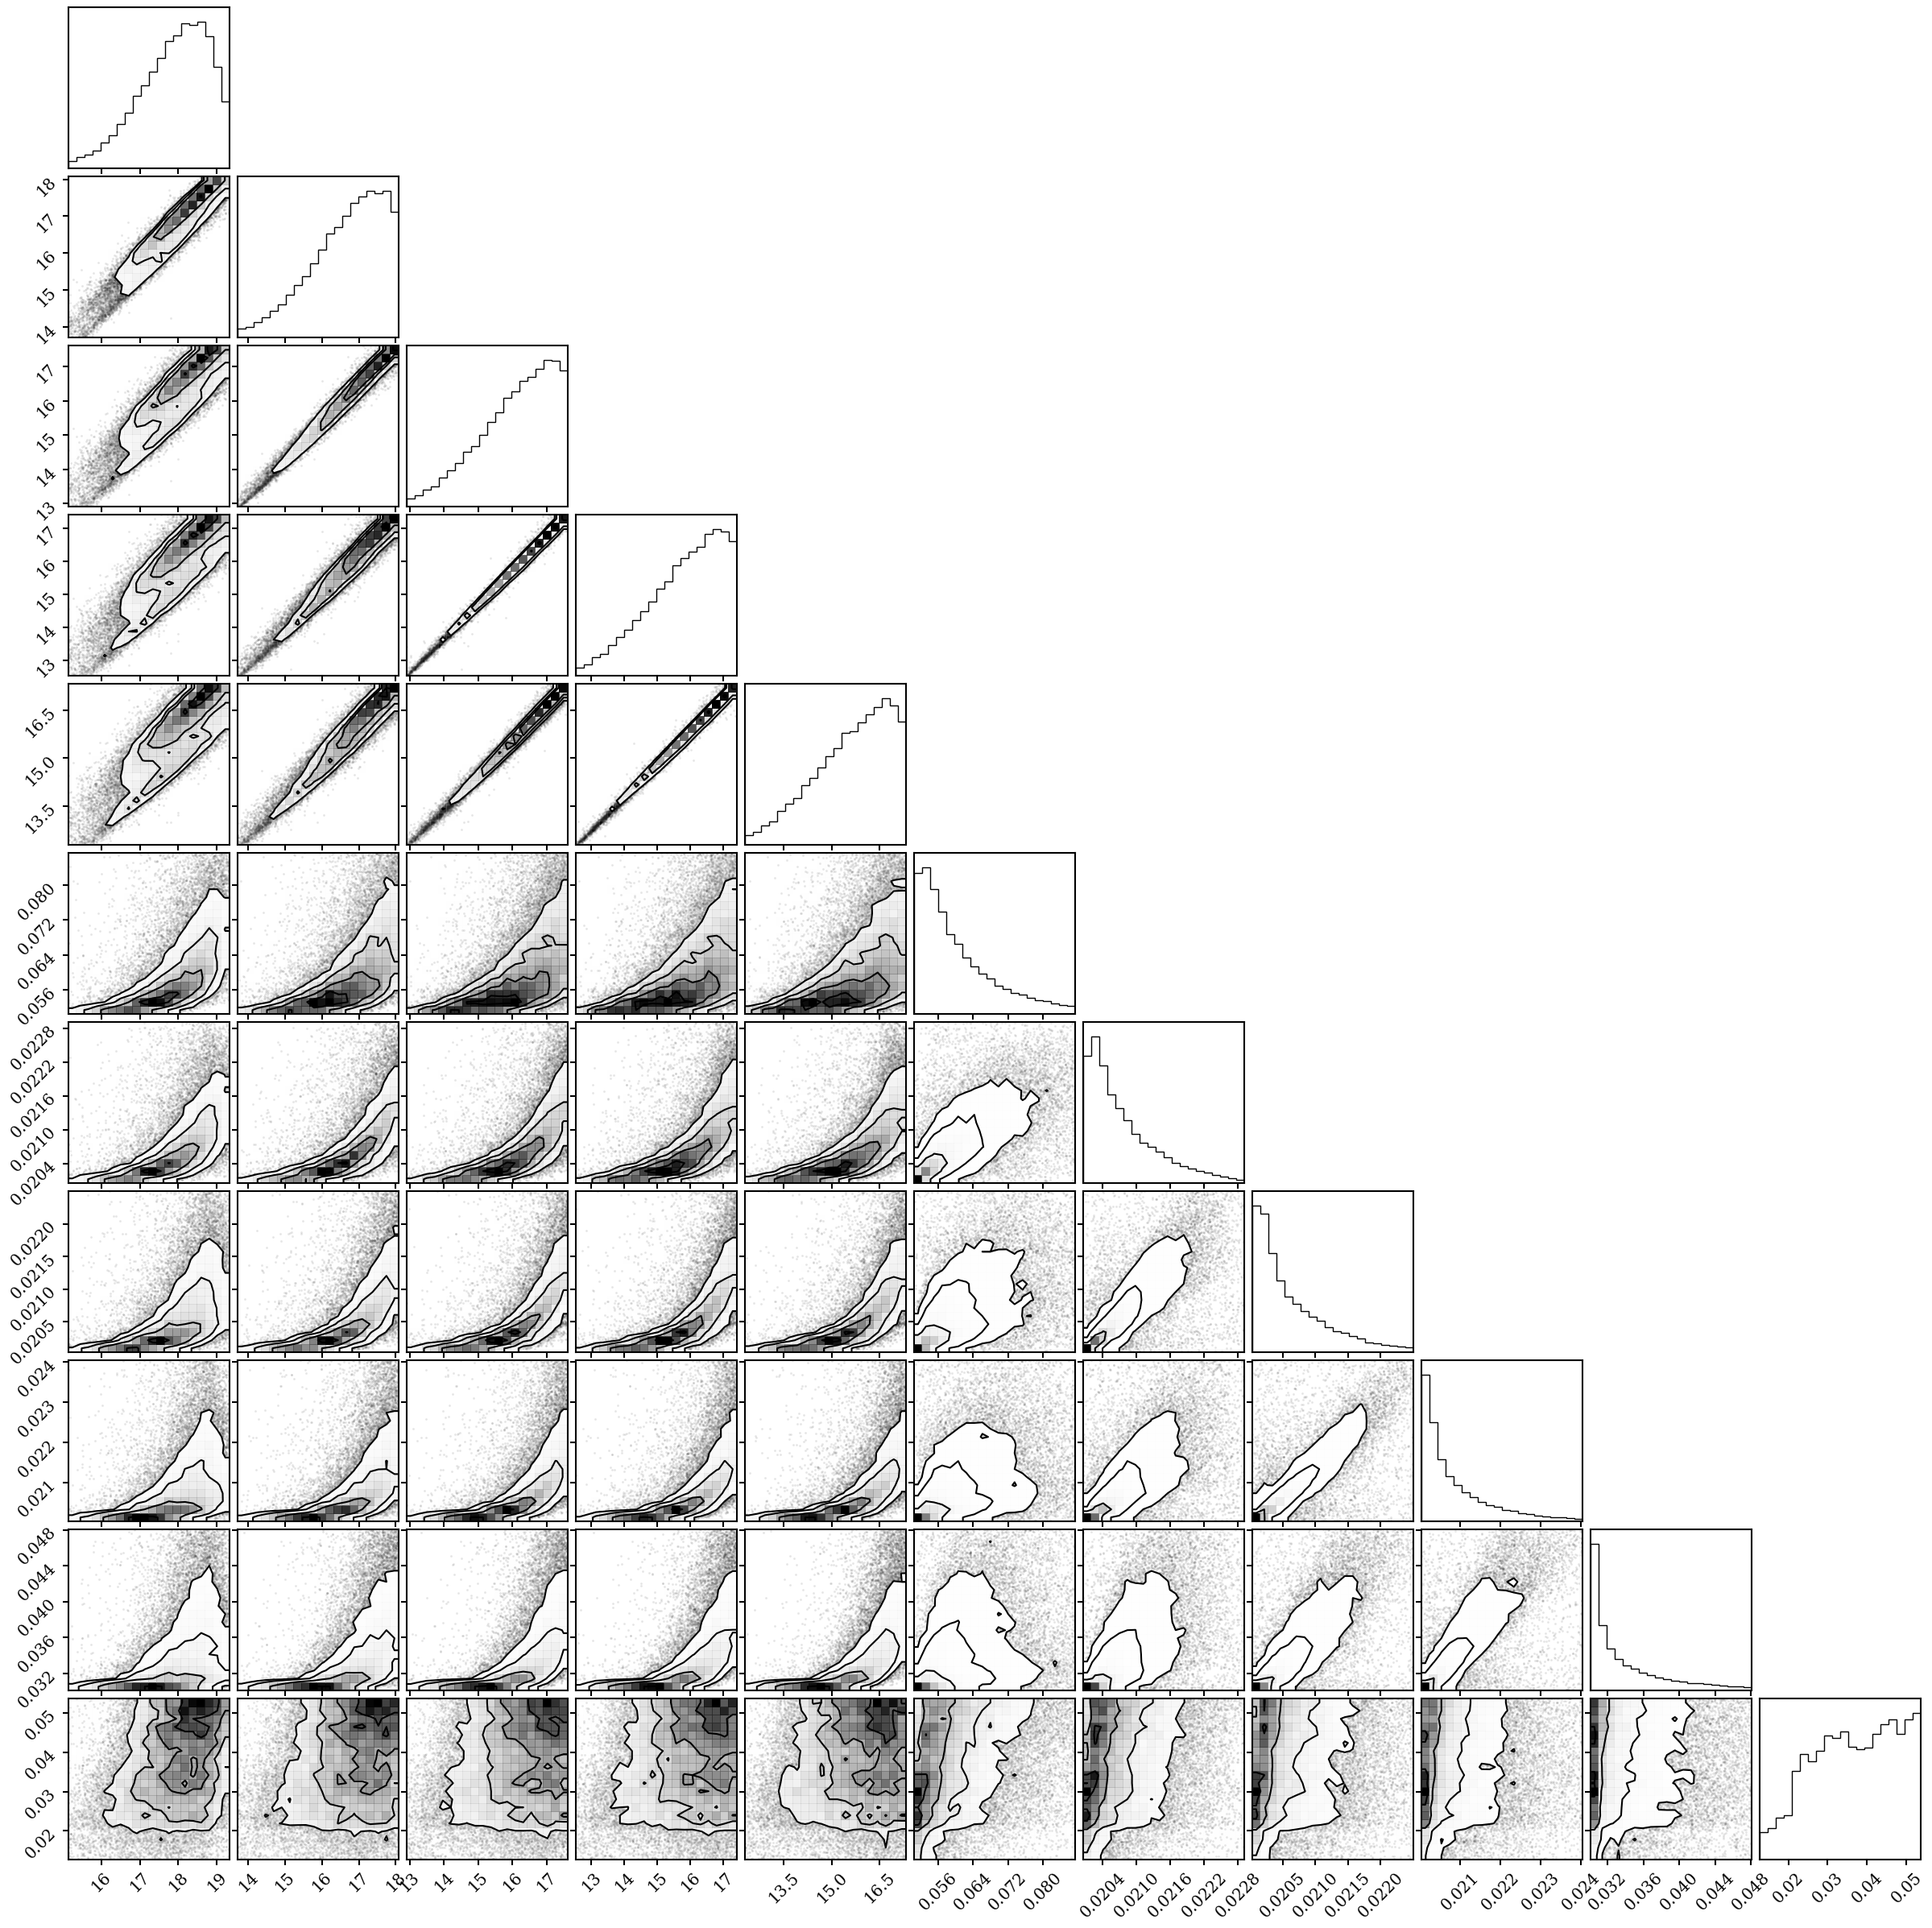

In [7]:
fig = DFM.corner(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), 
                 range=np.quantile(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T)

# Lets train $p(x|y) = p(\sigma | {\rm mag}, z)$

In [8]:
x_train = sigs_nsa
y_train = np.concatenate([mags_nsa, zred_nsa[:,None]], axis=1)

In [9]:
print('Ntrain = %i' % x_train.shape[0])
num_inputs      = x_train.shape[1]
num_cond_inputs = y_train.shape[1]
print('d[x] = %i, d[y] = %i' % (num_inputs, num_cond_inputs))

Ntrain = 30346
d[x] = 5, d[y] = 6


In [11]:
lower_bounds = torch.tensor([0., 0., 0., 0., 0.])
upper_bounds = torch.tensor(np.max(x_train, axis=0))

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

 Neural network successfully converged after 125 epochs.

(0.0, 125.0)

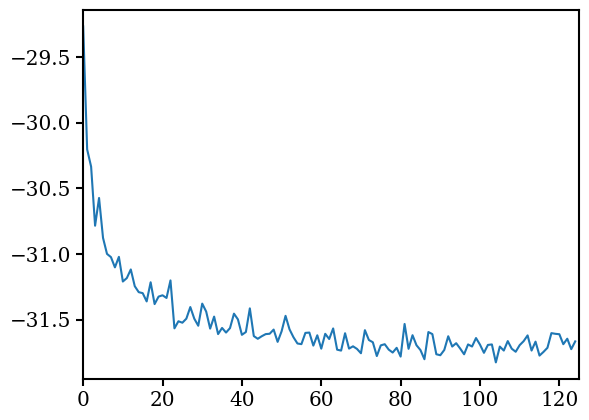

In [13]:
anpe = Inference.SNPE(prior=prior, density_estimator=Ut.posterior_nn('maf', hidden_features=100), device='cpu')
anpe.append_simulations(
    torch.as_tensor(x_train.astype(np.float32)), 
    torch.as_tensor(y_train.astype(np.float32)))

p_x_y_estimator = anpe.train()

plt.plot(-np.array(anpe._summary['validation_log_probs']))
plt.xlim(0, len(anpe._summary['validation_log_probs']))

In [15]:
# save trained ANPE
dat_dir = '/media/SSD/Doktori/Csillagtomegbecsles_cikk/SED/SEDflow/SEDflow/nb/reproducing/'
torch.save(p_x_y_estimator.state_dict(), dat_dir + 'nsa_noise_flow.pt')

In [16]:
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

In [17]:
x_test = [] 
for i in range(1000): 
    x_test.append(np.array(hatp_x_y.sample((1,), x=torch.as_tensor(y_train[i])).to('cpu'))[0])

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

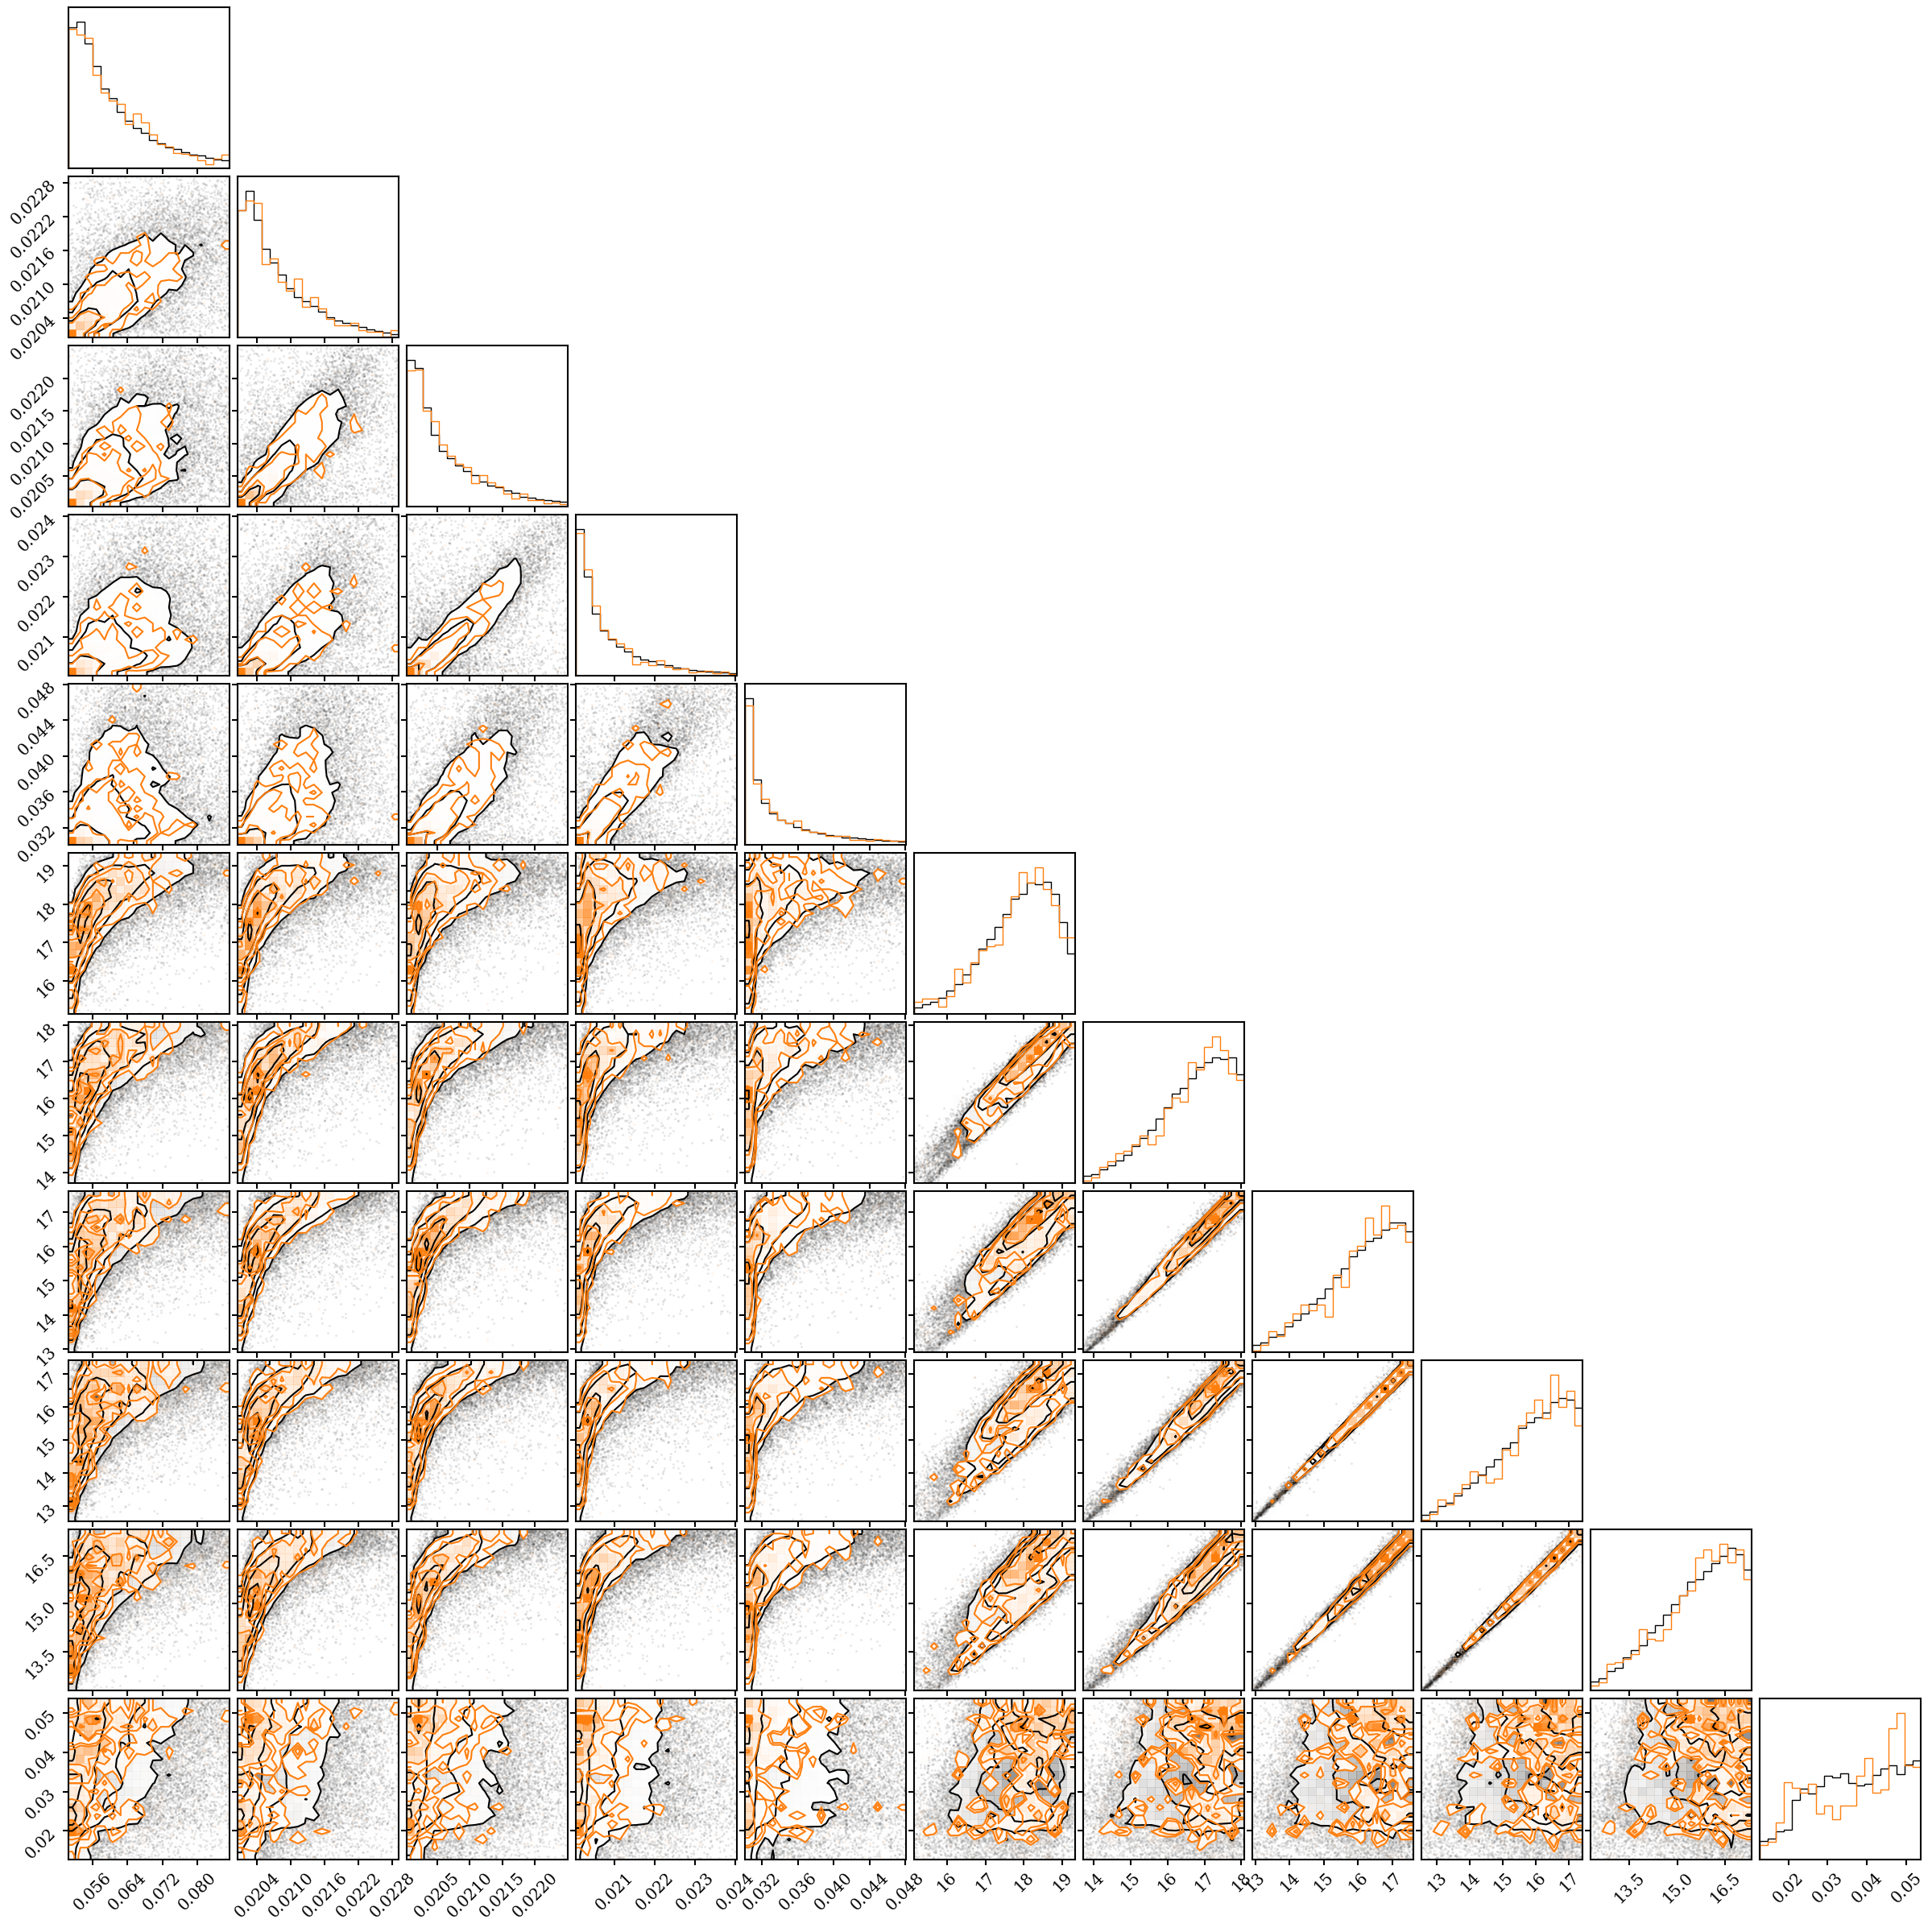

In [18]:
fig = DFM.corner(np.concatenate([sigs_nsa, mags_nsa, zred_nsa[:,None]], axis=1), 
                 range=np.quantile(np.concatenate([sigs_nsa, mags_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T, 
                 hist_kwargs={'density': True}
                )
_ = DFM.corner(np.concatenate([x_test, y_train[:1000]], axis=1), color='C1', fig=fig, 
               range=np.quantile(np.concatenate([sigs_nsa, mags_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T, 
               hist_kwargs={'density': True}
              )